# This notebook contains initial EDA (and 1st round classification) of the Yummly dataset. 
## Author: Aaron W Chen

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
# Also try a baseline with regular KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

---

## Import data

In [2]:
train_data_path = '../data/raw/train.json'
data = pd.read_json(train_data_path)
data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## Preview Raw Imported DataFrame

In [3]:
data.groupby('cuisine').count()

,id,ingredients
cuisine,,
brazilian,467,467
british,804,804
cajun_creole,1546,1546
chinese,2673,2673
filipino,755,755
french,2646,2646
greek,1175,1175
indian,3003,3003
irish,667,667


In [4]:
targets = data.cuisine
targets

0              greek
1        southern_us
2           filipino
3             indian
4             indian
            ...     
39769          irish
39770        italian
39771          irish
39772        chinese
39773        mexican
Name: cuisine, Length: 39774, dtype: object

In [5]:
recipes = data.ingredients
recipes

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
39769    [light brown sugar, granulated sugar, butter, ...
39770    [KRAFT Zesty Italian Dressing, purple onion, b...
39771    [eggs, citrus fruit, raisins, sourdough starte...
39772    [boneless chicken skinless thigh, minced garli...
39773    [green chile, jalapeno chilies, onions, ground...
Name: ingredients, Length: 39774, dtype: object

In [6]:
skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(recipes, targets):
    recipes_train, recipes_val = recipes[train_index], recipes[val_index]
    targets_train, targets_val = targets[train_index], targets[val_index]

In [7]:
le = LabelEncoder()
le.fit(targets_train)

LabelEncoder()

In [8]:
le.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [9]:
transformed_targets_train = le.transform(targets_train)

In [10]:
transformed_targets_train

array([ 6, 16,  4, ...,  2,  2,  2])

In [11]:
le.inverse_transform(transformed_targets_train)

array(['greek', 'southern_us', 'filipino', ..., 'cajun_creole',
       'cajun_creole', 'cajun_creole'], dtype=object)

In [12]:
all_words = [item for elem in recipes_train for item in elem]

In [13]:
all_words[:5], len(all_words)

(['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper'],
 285089)

In [14]:
recipes_train

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
26906    [milk, baking powder, all-purpose flour, sugar...
26954    [worcestershire sauce, celery, ground black pe...
26960    [garlic, fresh parsley, chicken stock, long gr...
26969    [green chile, seasoning salt, diced tomatoes, ...
26982    [Johnsonville Smoked Sausage, water, stewed to...
Name: ingredients, Length: 26516, dtype: object

In [15]:
tfidf_vec_unigram = TfidfVectorizer(token_pattern=r"(?u)\b[a-zA-Z]{2,}\b")

In [16]:
x = tfidf_vec_unigram.fit(all_words)

1. Add support for bigrams, trigrams, maybe quadgrams
2. Lemmatize ingredients to remove plurals and duplicates

In [17]:
x

TfidfVectorizer(token_pattern='(?u)\\b[a-zA-Z]{2,}\\b')

In [18]:
recipes_train_uni_vec = tfidf_vec_unigram.transform(recipes_train.apply(" ".join).str.lower())
word_matrix = pd.DataFrame(recipes_train_uni_vec.toarray(), 
                            columns=tfidf_vec_unigram.get_feature_names(), 
                            index=recipes_train.index
                        )

In [19]:
word_matrix

,abalone,abbamele,absinthe,abura,acai,accent,accompaniment,achiote,acid,acini,...,yuzu,yuzukosho,za,zatarain,zero,zest,zesty,zinfandel,ziti,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.231513,0.0,0.0,0.0,0.0
26954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
26960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
26969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [20]:
word_matrix.columns[201:220]

Index(['biga', 'bihon', 'bing', 'bird', 'biryani', 'biscotti', 'biscuit',
       'biscuits', 'bison', 'bisquick', 'bits', 'bitter', 'bitters',
       'bittersweet', 'blacan', 'black', 'blackberries', 'blackberry',
       'blackcurrant'],
      dtype='object')

In [21]:
word_matrix.iloc[0]

abalone      0.0
abbamele     0.0
absinthe     0.0
abura        0.0
acai         0.0
            ... 
zest         0.0
zesty        0.0
zinfandel    0.0
ziti         0.0
zucchini     0.0
Name: 0, Length: 2771, dtype: float64

In [22]:
word_matrix.iloc[0][word_matrix.iloc[0] > 0]

beans        0.224367
black        0.181163
cheese       0.178052
crumbles     0.311264
feta         0.291110
garbanzo     0.343606
garlic       0.159290
grape        0.321816
lettuce      0.266857
olives       0.260341
onion        0.198533
pepper       0.147376
purple       0.248575
romaine      0.317171
seasoning    0.240609
tomatoes     0.189996
Name: 0, dtype: float64

In [23]:
recipes_train.iloc[0]

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [24]:
lr_uni_tfidf_ovr = LogisticRegression(multi_class = 'ovr',
                                      class_weight = 'balanced',
                                      #solver = 'liblinear',
                                      max_iter = 1000,
                                      random_state = 50)
lr_uni_tfidf_ovr.fit(word_matrix, targets_train)
train_pred_tfidf_uni_ovr = lr_uni_tfidf_ovr.predict(word_matrix)

In [25]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [26]:
acc_lr_uni_tfidf_ovr, prec_lr_uni_tfidf_ovr, recall_lr_uni_tfidf_ovr, f1_lr_uni_tfidf_ovr = get_metrics(targets_train, train_pred_tfidf_uni_ovr)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (acc_lr_uni_tfidf_ovr, prec_lr_uni_tfidf_ovr, recall_lr_uni_tfidf_ovr, f1_lr_uni_tfidf_ovr))

accuracy = 0.816, precision = 0.830, recall = 0.816, f1 = 0.820


In [27]:
reci_val_uni_vec = tfidf_vec_unigram.transform(recipes_val.apply(" ".join).str.lower())
word_matrix_val = pd.DataFrame(reci_val_uni_vec.toarray(), 
                            columns=tfidf_vec_unigram.get_feature_names(), 
                            index=recipes_val.index
                        )

In [28]:
val_pred_tfidf_uni_ovr = lr_uni_tfidf_ovr.predict(word_matrix_val)

In [29]:
val_acc_lr_uni_tfidf_ovr, val_prec_lr_uni_tfidf_ovr, val_recall_lr_uni_tfidf_ovr, val_f1_lr_uni_tfidf_ovr = get_metrics(targets_val, val_pred_tfidf_uni_ovr)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (val_acc_lr_uni_tfidf_ovr, val_prec_lr_uni_tfidf_ovr, val_recall_lr_uni_tfidf_ovr, val_f1_lr_uni_tfidf_ovr))

accuracy = 0.763, precision = 0.776, recall = 0.763, f1 = 0.768


In [30]:
test_data_path = '../data/raw/test.json'
test_data = pd.read_json(test_data_path)
test_data.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

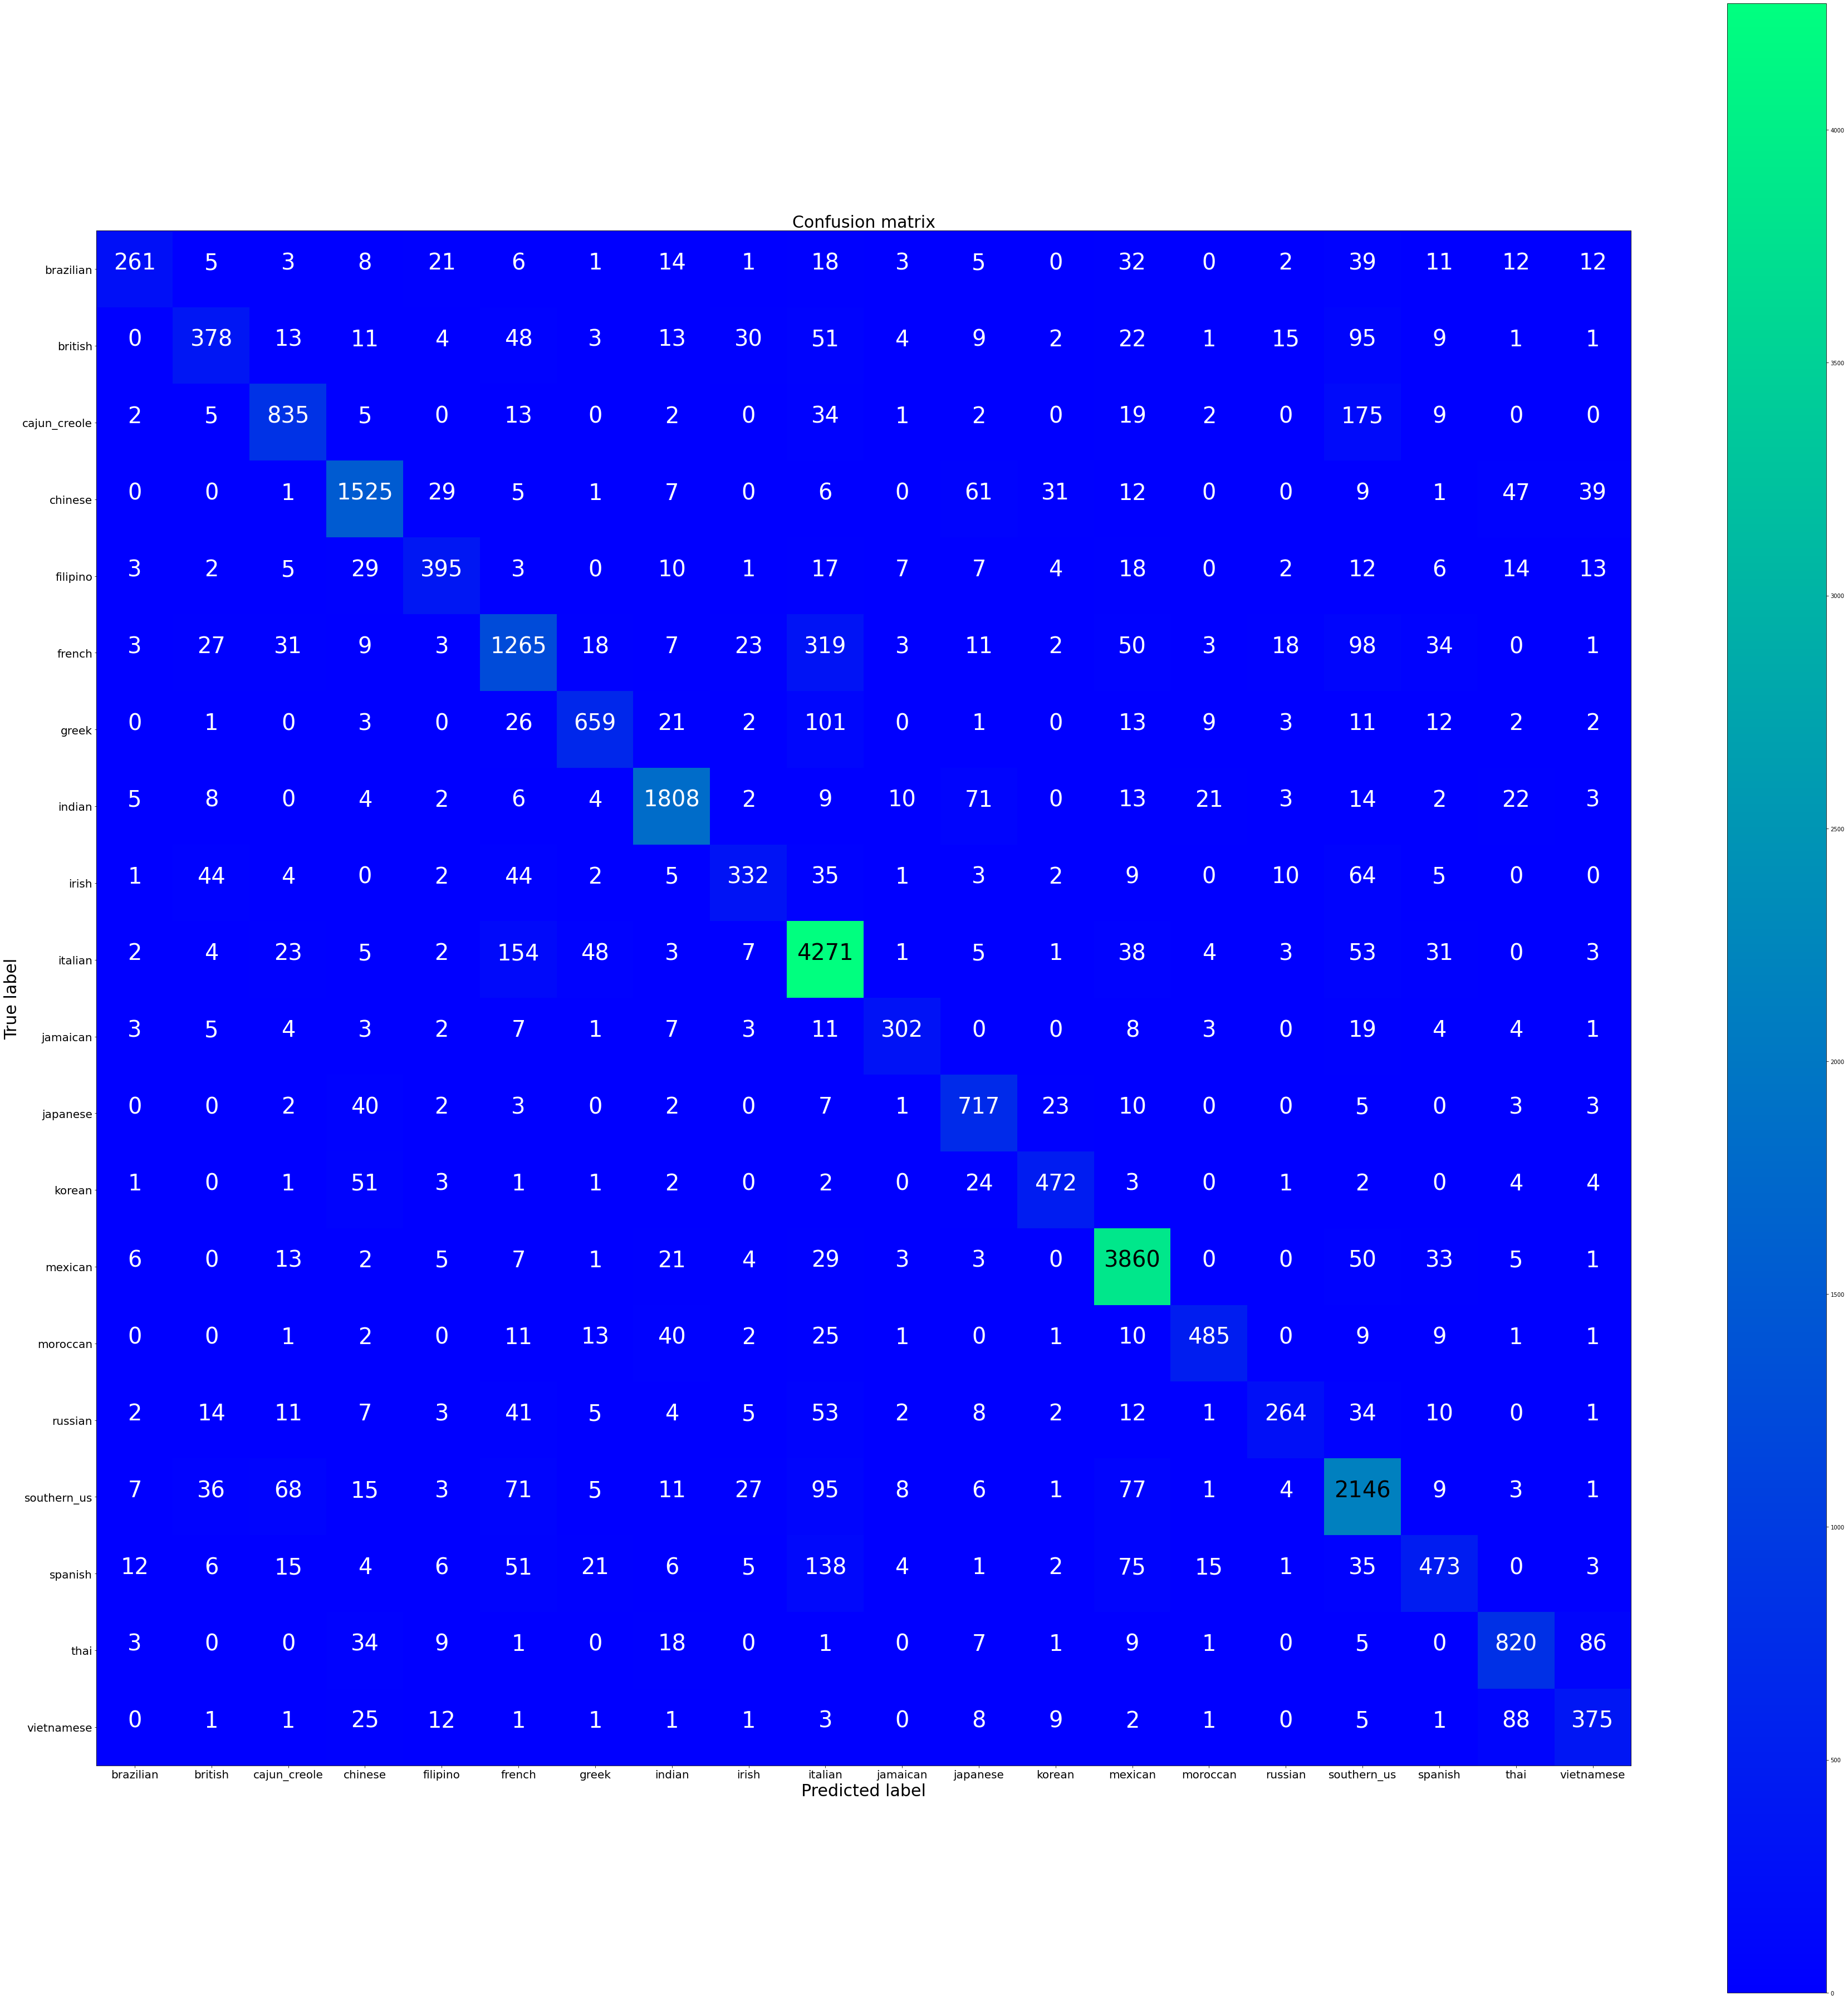

[[ 261    5    3    8   21    6    1   14    1   18    3    5    0   32
     0    2   39   11   12   12]
 [   0  378   13   11    4   48    3   13   30   51    4    9    2   22
     1   15   95    9    1    1]
 [   2    5  835    5    0   13    0    2    0   34    1    2    0   19
     2    0  175    9    0    0]
 [   0    0    1 1525   29    5    1    7    0    6    0   61   31   12
     0    0    9    1   47   39]
 [   3    2    5   29  395    3    0   10    1   17    7    7    4   18
     0    2   12    6   14   13]
 [   3   27   31    9    3 1265   18    7   23  319    3   11    2   50
     3   18   98   34    0    1]
 [   0    1    0    3    0   26  659   21    2  101    0    1    0   13
     9    3   11   12    2    2]
 [   5    8    0    4    2    6    4 1808    2    9   10   71    0   13
    21    3   14    2   22    3]
 [   1   44    4    0    2   44    2    5  332   35    1    3    2    9
     0   10   64    5    0    0]
 [   2    4   23    5    2  154   48    3    7 4271    

In [32]:
cm_train = confusion_matrix(train_pred_tfidf_uni_ovr, targets_train)
fig_train = plt.figure(figsize=(50, 50))
plot_train = plot_confusion_matrix(cm_train, classes=le.classes_, normalize=False, title='Confusion matrix')
plt.show()
print(cm_train)

In [33]:
targets_train

0               greek
1         southern_us
2            filipino
3              indian
4              indian
             ...     
26906    cajun_creole
26954    cajun_creole
26960    cajun_creole
26969    cajun_creole
26982    cajun_creole
Name: cuisine, Length: 26516, dtype: object

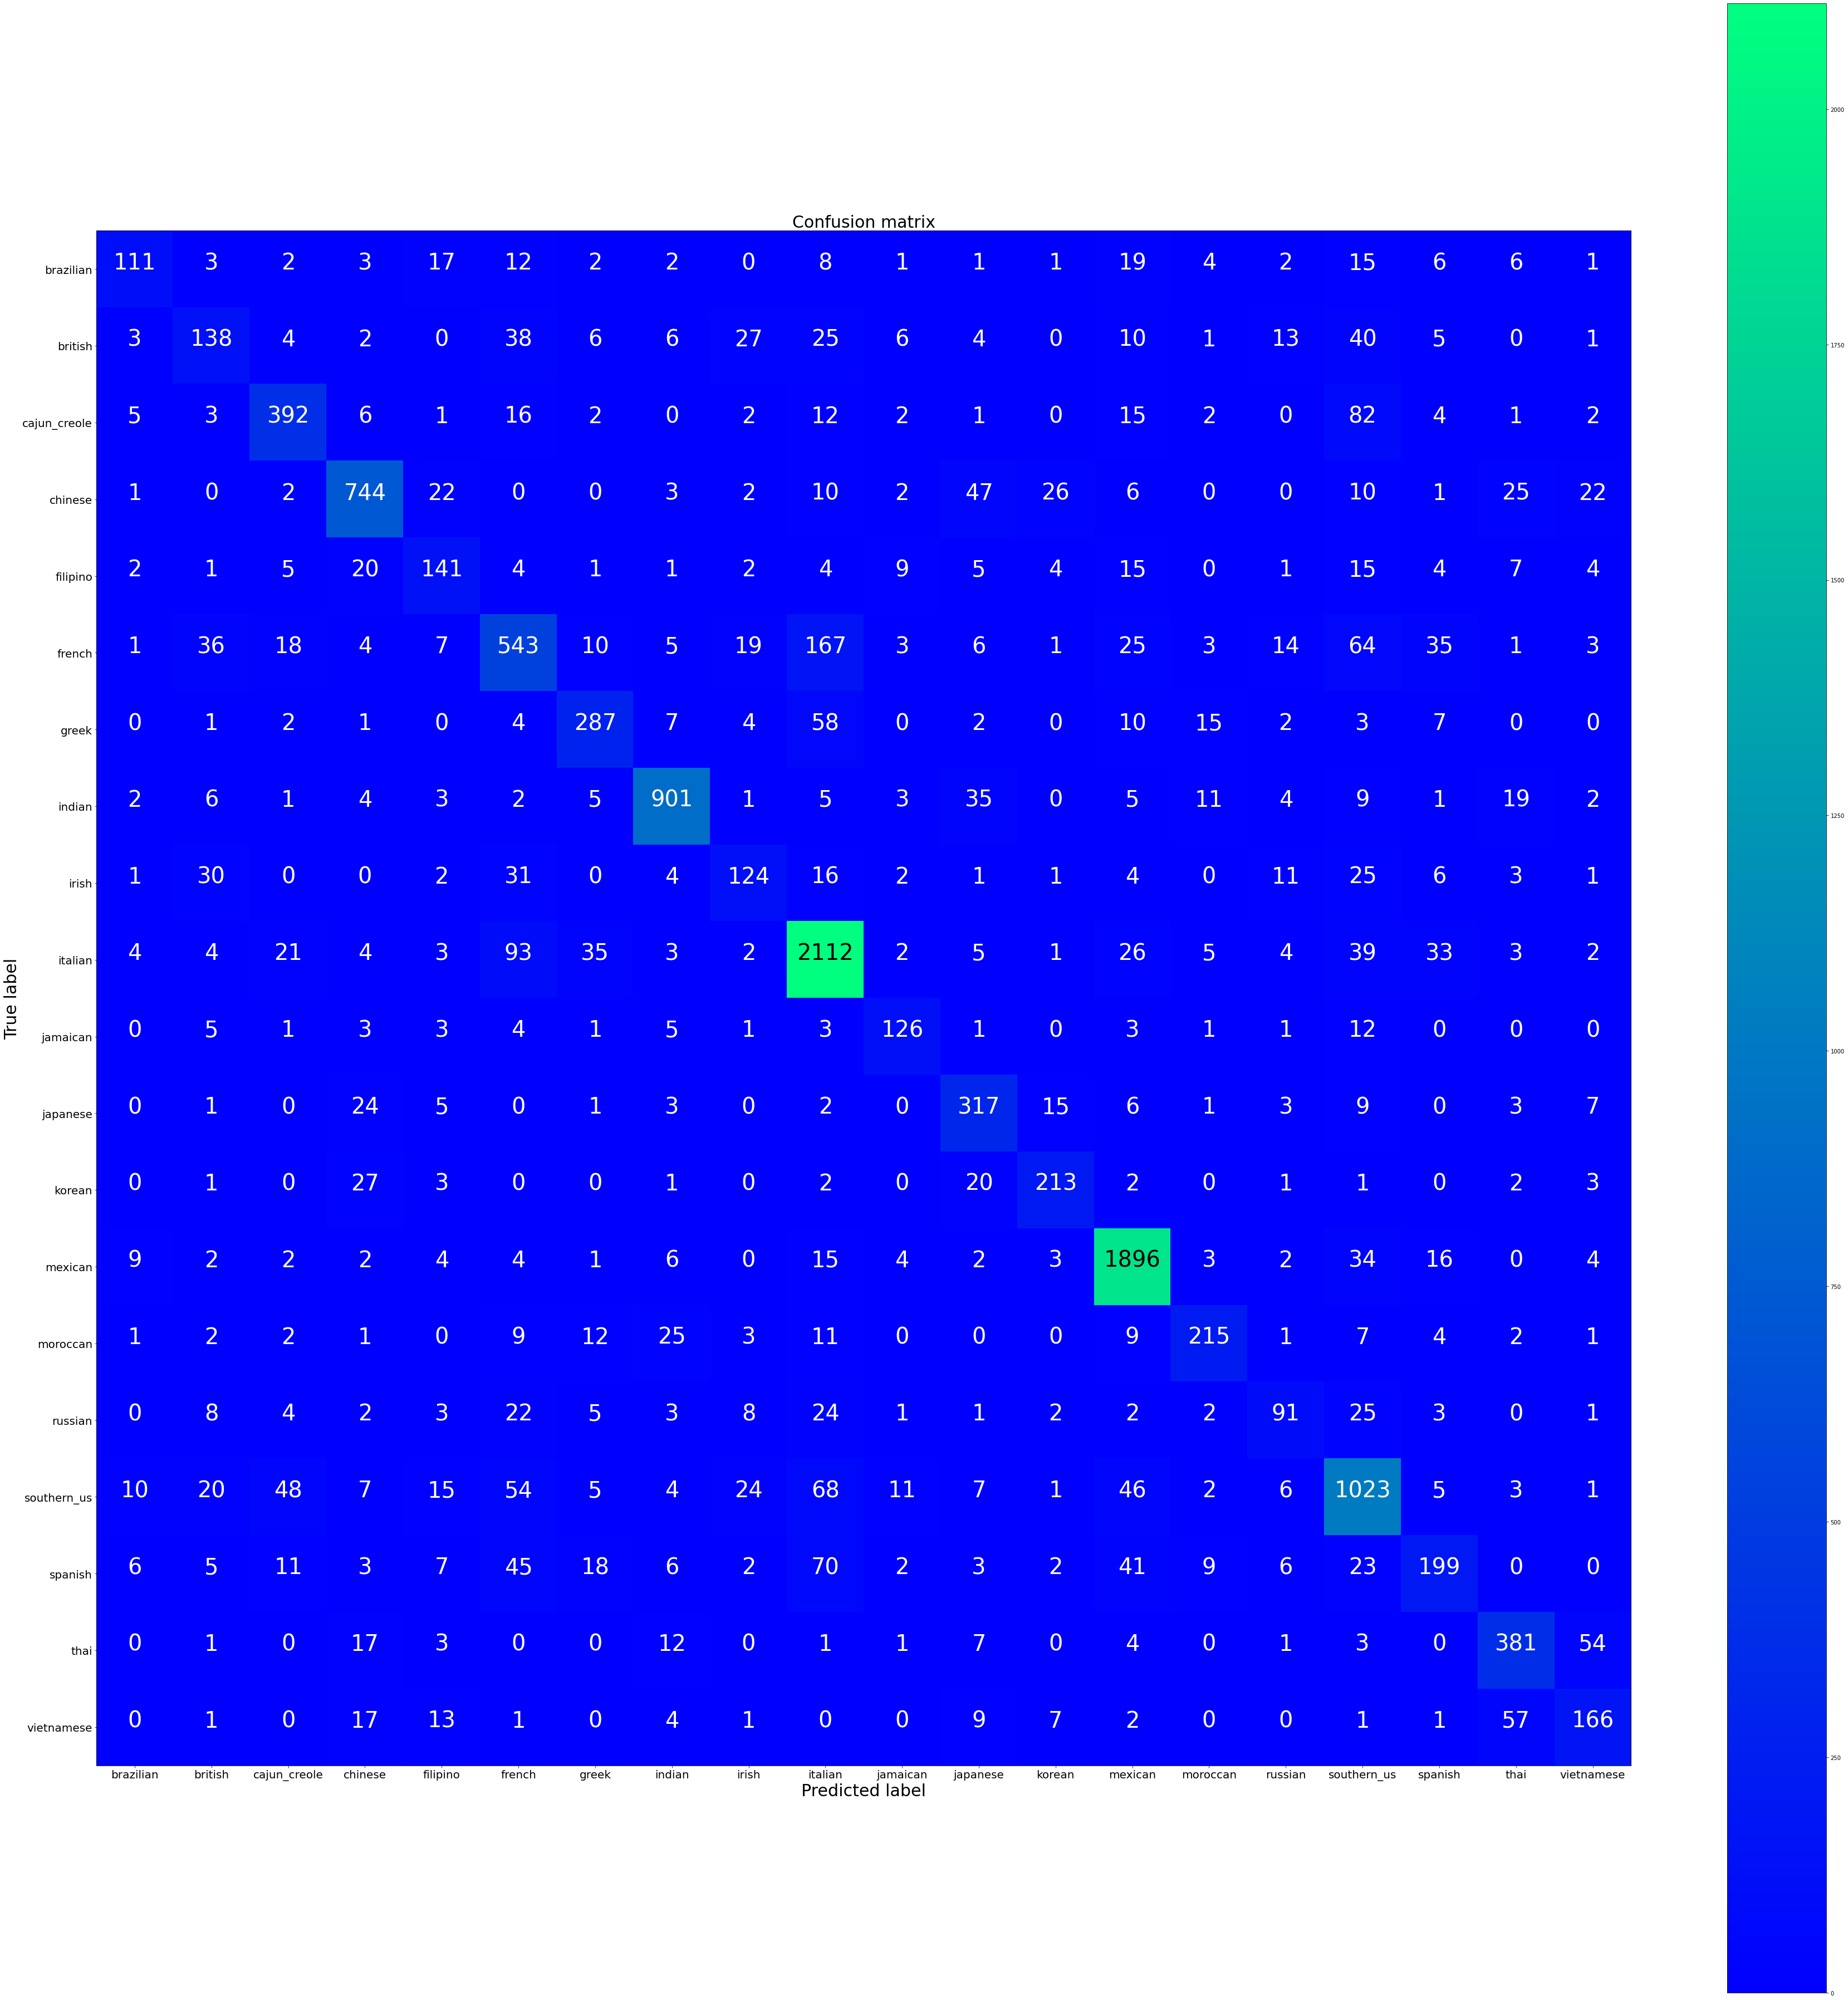

[[ 111    3    2    3   17   12    2    2    0    8    1    1    1   19
     4    2   15    6    6    1]
 [   3  138    4    2    0   38    6    6   27   25    6    4    0   10
     1   13   40    5    0    1]
 [   5    3  392    6    1   16    2    0    2   12    2    1    0   15
     2    0   82    4    1    2]
 [   1    0    2  744   22    0    0    3    2   10    2   47   26    6
     0    0   10    1   25   22]
 [   2    1    5   20  141    4    1    1    2    4    9    5    4   15
     0    1   15    4    7    4]
 [   1   36   18    4    7  543   10    5   19  167    3    6    1   25
     3   14   64   35    1    3]
 [   0    1    2    1    0    4  287    7    4   58    0    2    0   10
    15    2    3    7    0    0]
 [   2    6    1    4    3    2    5  901    1    5    3   35    0    5
    11    4    9    1   19    2]
 [   1   30    0    0    2   31    0    4  124   16    2    1    1    4
     0   11   25    6    3    1]
 [   4    4   21    4    3   93   35    3    2 2112    

In [34]:
cm_val = confusion_matrix(val_pred_tfidf_uni_ovr, targets_val)
fig_val = plt.figure(figsize=(50, 50))
plot_val = plot_confusion_matrix(cm_val, classes=le.classes_, normalize=False, title='Confusion matrix')
plt.show()
print(cm_val)

In [35]:
targets_val, val_pred_tfidf_uni_ovr 
macro_roc_auc_ovo = roc_auc_score(targets_val, val_pred_tfidf_uni_ovr, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(targets_val, val_pred_tfidf_uni_ovr, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(targets_val, val_pred_tfidf_uni_ovr, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(targets_val, val_pred_tfidf_uni_ovr, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

ValueError: could not convert string to float: 'southern_us'

In [ ]:
def get_most_important_features(vectorizer, model, encoder, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[le.classes_[class_index]] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [ ]:
train_importance = get_most_important_features(tfidf_vec_unigram, lr_uni_tfidf_ovr, le, 10)

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Strongest Negative Affiliation', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Strongest Positive Affiliation', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [ ]:
for cuisine in le.classes_:
    train_top_scores = [a[0] for a in train_importance[cuisine]['tops']]
    train_top_words = [a[1] for a in train_importance[cuisine]['tops']]
    train_bottom_scores = [a[0] for a in train_importance[cuisine]['bottom']]
    train_bottom_words = [a[1] for a in train_importance[cuisine]['bottom']]

    plot_important_words(train_top_scores, train_top_words, train_bottom_scores, train_bottom_words, f"Most and Least Relevant Ingredients for {cuisine} in training set")

Brian pointed out that these are already in tokens. Can you flatten the list of lists BUT preserve the original tokens e.g. "olive oil" doesn't get turned into "olive" and "oil"

Oh, the words are individualized to allow lemmatization to work...
Could it be possible to rejoin lemmatized words? Or would it be better to skip lemmatization
    Wait you didn't use a lemmatizer so just try with the original ingredient "tokens"

In [39]:
recipes_train

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
26906    [milk, baking powder, all-purpose flour, sugar...
26954    [worcestershire sauce, celery, ground black pe...
26960    [garlic, fresh parsley, chicken stock, long gr...
26969    [green chile, seasoning salt, diced tomatoes, ...
26982    [Johnsonville Smoked Sausage, water, stewed to...
Name: ingredients, Length: 26516, dtype: object

In [42]:
flattened_list = [ingred for recipe in recipes_train for ingred in recipe]

In [47]:
recipes_train.apply(" ".join).str.lower()

0        romaine lettuce black olives grape tomatoes ga...
1        plain flour ground pepper salt tomatoes ground...
2        eggs pepper salt mayonaise cooking oil green c...
3                           water vegetable oil wheat salt
4        black pepper shallots cornflour cayenne pepper...
                               ...                        
26906    milk baking powder all-purpose flour sugar uns...
26954    worcestershire sauce celery ground black peppe...
26960    garlic fresh parsley chicken stock long grain ...
26969    green chile seasoning salt diced tomatoes ham ...
26982    johnsonville smoked sausage water stewed tomat...
Name: ingredients, Length: 26516, dtype: object

In [48]:
recipes_train

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
26906    [milk, baking powder, all-purpose flour, sugar...
26954    [worcestershire sauce, celery, ground black pe...
26960    [garlic, fresh parsley, chicken stock, long gr...
26969    [green chile, seasoning salt, diced tomatoes, ...
26982    [Johnsonville Smoked Sausage, water, stewed to...
Name: ingredients, Length: 26516, dtype: object

In [57]:
tfidf_vec_unigram_2 = TfidfVectorizer(analyzer='char_wb')
x_2 = tfidf_vec_unigram_2.fit(all_words)
recipes_train_uni_vec_2 = tfidf_vec_unigram_2.transform(flattened_list)

In [58]:
recipes_train_uni_vec_2.toarray()

array([[0.458414  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48525687, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.45568825, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.35393374, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35827597, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.36866181, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [59]:
tfidf_vec_unigram_2.get_feature_names()

[' ',
 '!',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '®',
 'â',
 'ç',
 'è',
 'é',
 'í',
 'î',
 'ú',
 '’',
 '€',
 '™']

In [ ]:
word_matrix = pd.DataFrame(recipes_train_uni_vec.toarray(), 
                            columns=tfidf_vec_unigram.get_feature_names(), 
                            index=recipes_train.index
                        )